#### Notes on current version:
**Done**:

- $\checkmark$ Cayley parameterization](https://planetmath.org/cayleysparameterizationoforthogonalmatrices) of $SU_d$ (since this is really all we need)...*will it be more stable than Lie's parameterization?* Note: it is a homeomorphism so this is great for UAP!

**To do:**
  
- Implement Regression

- Implement Feature Map

# NEU (Reconfigurations Map and Related Functions)

### Basic Algorithm (NEU-OLS)

1. Perform Basic Algorithm (in this case OLS)
2. Map predictions to their graph; ie $x\mapsto (x,\hat{f}_{OLS}(x))$ where $\hat{f}_{OLS}$ is the least-squares regression function.

## Initializations:

In [96]:
# Data Structuring
import numpy as np
import pandas as pd


# Regression
from sklearn.linear_model import LinearRegression
from scipy import linalg as scila

# Tensorflow
import tensorflow as tf
import tensorflow_probability as tfp
import keras as K
import keras.backend as Kb
from keras.layers import *
from keras.models import Model
from keras.models import Sequential
from keras import layers
from keras import utils as np_utils
from tensorflow.keras.initializers import RandomUniform
from tensorflow.keras.constraints import NonNeg


# Operating-System Related
import os
from pathlib import Path

# Visualization
from matplotlib.pyplot import figure

# z_Misc
import time
import math

## Check/Make Paths

In [97]:
Path('./outputs/models/').mkdir(parents=True, exist_ok=True)
Path('./outputs/models/Benchmarks/').mkdir(parents=True, exist_ok=True)
Path('./outputs/models/NEU/').mkdir(parents=True, exist_ok=True)
Path('./outputs/models/NEU/Greedy_Initializations/').mkdir(parents=True, exist_ok=True)
Path('./outputs/tables/').mkdir(parents=True, exist_ok=True)
Path('./outputs/results/').mkdir(parents=True, exist_ok=True)
Path('./inputs/data/').mkdir(parents=True, exist_ok=True)

## Initialize Internal Variables/(Hyper)parameter(s)

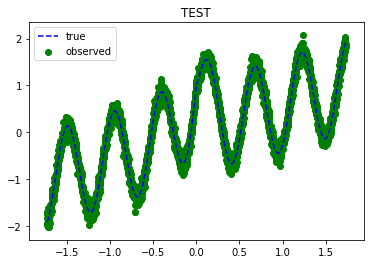

In [88]:
N_Reconfigurations = 20
d = 1 # Dimension of X
D = 1 # Dimension of Y


# Data Meta-Parameters
noise_level = 0.1
uncertainty_level= 0.5

# Training meta-parameters
Pre_Epochs = 10
Full_Epochs = 100

# Depth & Height of first Reconfiguration
Initial_Depth = 20
Initial_Height = 20

# Depth & Height Per Reconfiguration
Depth_per_reconfig = 5
Height_per_reconfig = 20

# Number of Datapoints
N_data = 10**3

# Unknown Function
def unknown_f(x):
    return .1*x + np.exp(-np.abs(x)) + np.sin(2*x)

# Generate Data
%run Data_Generator.ipynb

# Import Custom Layer(s)
%run Special_Layers_Homeomorphic.ipynb

# Import Utility for NEU
%run NEU_Util.ipynb

# Import Benchmarks
%run Benchmarks_Util.ipynb

#### Prepare data for NEU

In [98]:
# Reshape Data Into Compatible Shape
data_x = np.array(data_x).reshape(-1,d)
data_y = np.array(data_y)
# Perform OLS Regression
linear_model = LinearRegression()
reg = linear_model.fit(data_x, data_y)
model_pred_y = linear_model.predict(data_x)
# Map to Graph
data_NEU = np.concatenate((data_x,model_pred_y.reshape(-1,D)),1)
NEU_targets_full  = np.concatenate((data_x,data_y.reshape(-1,D)),1)
NEU_targets  = data_y.reshape(-1,D)

# Train NEU-OLS
- Get Base Model,
- Greedy Layer-Wise Initialization,
- SGD on entire structure.

In [99]:
if os.path.exists("./outputs/models/NEU/Greedy_Initializations/saved_model.pb"):

    print('I tiny!')
else:
    # Greedy Initialization
    model = get_base_model(data_NEU,NEU_targets,10,Initial_Depth,Initial_Height)
    NEU_OLS_Greedy_init = model
    for i in range(N_Reconfigurations):
        # Update User on Status of Initialization
        print(((i+1)/N_Reconfigurations))

        # Update Model
        NEU_OLS_Greedy_init_temp = add_reconfiguration_unit_greedily(NEU_OLS_Greedy_init,
                                                                     data_NEU,
                                                                     NEU_targets_full,
                                                                     Pre_Epochs,
                                                                     Depth_per_reconfig,
                                                                     Height_per_reconfig)

        # Check for Blowup
        if math.isnan(np.mean(NEU_OLS_Greedy_init.predict(data_NEU))):
            NEU_OLS_Greedy_init = NEU_OLS_Greedy_init
            break
        else: #Update Model if not explosion
            NEU_OLS_Greedy_init = NEU_OLS_Greedy_init_temp

        #-------------#
        # Update User #
        #-------------#
        print(np.mean(np.abs((NEU_OLS_Greedy_init.predict(data_NEU) - NEU_targets_full)**2)))
        
    # Update User of Pre-Training Completion
    print('Complete: Pre-Training Readout Map on Input x Output Space!')
    
    #------------------------------------#
    # Save Greedily Initialized Layer(s) #
    #------------------------------------#
    print('Saving Pre-Trained Readout on Input x Output Space!')
    NEU_OLS_Greedy_init.save("./outputs/models/NEU/Greedy_Initializations/")

I tiny!


Next we train NEU-OLS, by unfreezing the greedily initialized layers and using SGD on the whole structure.

In [71]:
NEU_OLS = build_reconfiguration(model_greedy_initialized=NEU_OLS_Greedy_init, 
                                trainx = data_NEU, 
                                trainy = NEU_targets, 
                                Full_Epochs_in = Full_Epochs, 
                                height = Height_per_reconfig)

Train on 3334 samples
Epoch 1/100
3334/3334 [==============================] - 36s 11ms/sample - loss: 87.6298 - mse: 1.4367 - mae: 0.9761
Epoch 2/100
3334/3334 [==============================] - 2s 746us/sample - loss: 81.9342 - mse: 0.8991 - mae: 0.7844
Epoch 3/100
3334/3334 [==============================] - 2s 743us/sample - loss: 80.2757 - mse: 0.7443 - mae: 0.7270
Epoch 4/100
3334/3334 [==============================] - 3s 756us/sample - loss: 79.6630 - mse: 0.6874 - mae: 0.7051
Epoch 5/100
3334/3334 [==============================] - 3s 757us/sample - loss: 79.3769 - mse: 0.6633 - mae: 0.6951
Epoch 6/100
3334/3334 [==============================] - 3s 756us/sample - loss: 79.2563 - mse: 0.6524 - mae: 0.6911
Epoch 7/100
3334/3334 [==============================] - 3s 827us/sample - loss: 79.1906 - mse: 0.6461 - mae: 0.6889
Epoch 8/100
3334/3334 [==============================] - 3s 883us/sample - loss: 79.1428 - mse: 0.6415 - mae: 0.6871
Epoch 9/100
3334/3334 [===================

3334/3334 [==============================] - 3s 808us/sample - loss: 78.8013 - mse: 0.6087 - mae: 0.6753
Epoch 71/100
3334/3334 [==============================] - 3s 811us/sample - loss: 78.7893 - mse: 0.6086 - mae: 0.6753
Epoch 72/100
3334/3334 [==============================] - 3s 812us/sample - loss: 78.8119 - mse: 0.6086 - mae: 0.6753
Epoch 73/100
3334/3334 [==============================] - 3s 824us/sample - loss: 78.8042 - mse: 0.6086 - mae: 0.6752
Epoch 74/100
3334/3334 [==============================] - 3s 844us/sample - loss: 78.8036 - mse: 0.6086 - mae: 0.6753
Epoch 75/100
3334/3334 [==============================] - 3s 832us/sample - loss: 78.8091 - mse: 0.6086 - mae: 0.6753
Epoch 76/100
3334/3334 [==============================] - 3s 811us/sample - loss: 78.8094 - mse: 0.6086 - mae: 0.6753
Epoch 77/100
3334/3334 [==============================] - 3s 815us/sample - loss: 78.7939 - mse: 0.6085 - mae: 0.6753
Epoch 78/100
3334/3334 [==============================] - 3s 814us/sa

In [12]:
Deep_GLd = get_base_model_deep_GLd(data_NEU,
                                   NEU_targets,
                                   Full_Epochs_in = Full_Epochs, 
                                   depth = (N_Reconfigurations*Initial_Depth))

Train on 3334 samples
Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Epoch 37/100
Epoch 38/100
Epoch 39/100
Epoch 40/100
Epoch 41/100
Epoch 42/100
Epoch 43/100
Epoch 44/100
Epoch 45/100
Epoch 46/100
Epoch 47/100
Epoch 48/100
Epoch 49/100
Epoch 50/100
Epoch 51/100
Epoch 52/100
Epoch 53/100
Epoch 54/100
Epoch 55/100
Epoch 56/100
Epoch 57/100
Epoch 58/100
Epoch 59/100
Epoch 60/100
Epoch 61/100
Epoch 62/100
Epoch 63/100
Epoch 64/100
Epoch 65/100
Epoch 66/100
Epoch 67/100
Epoch 68/100
Epoch 69/100
Epoch 70/100
Epoch 71/100
Epoch 72/100
Epoch 73/100
Epoch 74/100
Epoch 75/100
Epoch 76/100

In [13]:
Deep_Ed=get_base_model_deep_Euclidean_Networks(data_NEU,
                                               NEU_targets,
                                               Full_Epochs_in = Full_Epochs, 
                                               depth = (N_Reconfigurations*Initial_Depth))

Train on 3334 samples
Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Epoch 37/100
Epoch 38/100
Epoch 39/100
Epoch 40/100
Epoch 41/100
Epoch 42/100
Epoch 43/100
Epoch 44/100
Epoch 45/100
Epoch 46/100
Epoch 47/100
Epoch 48/100
Epoch 49/100
Epoch 50/100
Epoch 51/100
Epoch 52/100
Epoch 53/100
Epoch 54/100
Epoch 55/100
Epoch 56/100
Epoch 57/100
Epoch 58/100
Epoch 59/100
Epoch 60/100
Epoch 61/100
Epoch 62/100
Epoch 63/100
Epoch 64/100
Epoch 65/100
Epoch 66/100
Epoch 67/100
Epoch 68/100
Epoch 69/100
Epoch 70/100
Epoch 71/100
Epoch 72/100
Epoch 73/100
Epoch 74/100
Epoch 75/100
Epoch 76/100

## Make Predictions

In [72]:
# # Predictions (for comparison: TEMP)
NEU_OLS_greedy_initializations = NEU_OLS_Greedy_init.predict(data_NEU)
NEU_OLS_prediction = NEU_OLS.predict(data_NEU)
Deep_GLd_prediction = Deep_GLd.predict(data_NEU)
Deep_Ed_prediction = Deep_Ed.predict(data_NEU)

#### Record Error(s)/Prediction Quality

In [124]:
# Quantile Losses 
#-----------------#
Results_MAE = np.array([np.mean(np.abs(NEU_OLS_prediction  - true_y)),
np.mean(np.abs(Deep_GLd_prediction  - true_y)),
np.mean(np.abs(Deep_Ed_prediction - true_y))])

Results_MinE = np.array([np.min(np.abs(NEU_OLS_prediction  - true_y)),
np.min(np.abs(Deep_GLd_prediction  - true_y)),
np.min(np.abs(Deep_Ed_prediction - true_y))])

Results_MaxE = np.array([np.max(np.abs(NEU_OLS_prediction  - true_y)),
np.max(np.abs(Deep_GLd_prediction  - true_y)),
np.max(np.abs(Deep_Ed_prediction - true_y))])

# Variance Losses
#----------------#
Results_MSE = np.array([np.mean(np.power(NEU_OLS_prediction  - true_y,2)),
np.mean(np.power(Deep_GLd_prediction  - true_y,2)),
np.mean(np.power(Deep_Ed_prediction - true_y,2))])

# Robust Loss
#-------------#
# Robust MAE
Results_rMAE = np.array([np.mean(np.exp(robustness_parameter*np.abs(NEU_OLS_prediction  - true_y))),
np.mean(np.exp(robustness_parameter*np.abs(Deep_GLd_prediction  - true_y))),
np.mean(np.exp(robustness_parameter*np.abs(Deep_Ed_prediction - true_y)))])

# Write to DataFrame
Results = pd.DataFrame({'MAE': Results_MAE,
                        'MinE': Results_MinE, 
                        'MaxE': Results_MaxE,
                        'Robust MAE':Results_rMAE,
                        'MSE':Results_MSE},
                        index={'NEU-OLS','Deep GLd','Deep ED'})

# Visualize Predictions

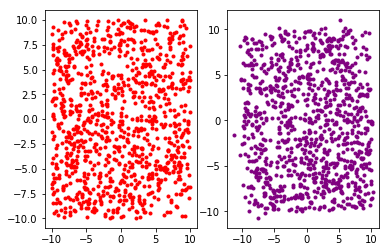

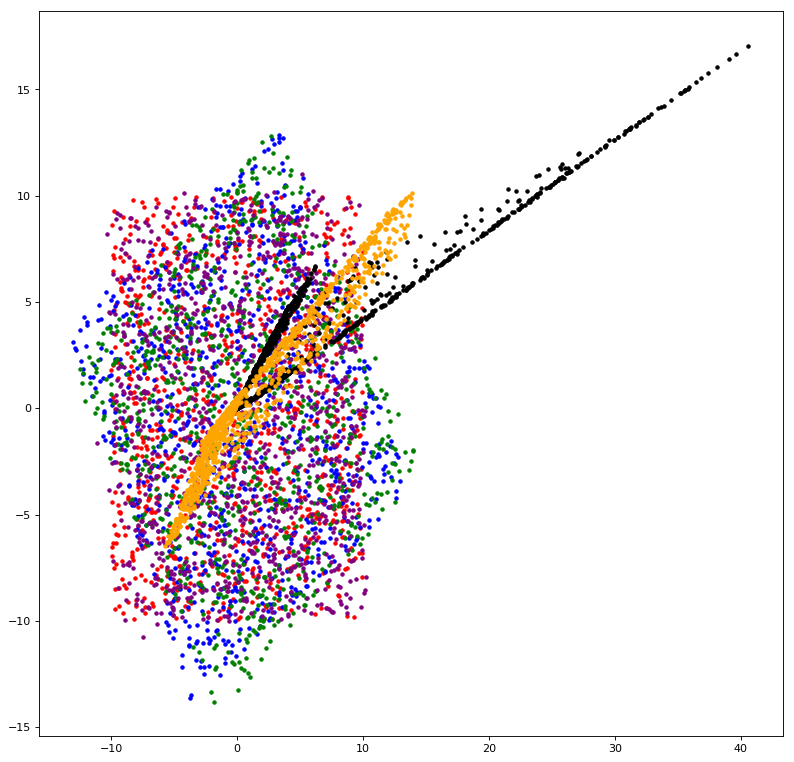

In [125]:
#---------------------------#
# Generate Transformed Data #
#---------------------------#
# Initialization of Grid
visualization_grid = np.random.uniform(-10,10,[10**3,2])
# Transform Data
NEU_OLS_prediction_visualization_Greedy = NEU_OLS_Greedy_init.predict(visualization_grid)
NEU_OLS_prediction_visualization = NEU_OLS.predict(visualization_grid)
Deep_GLd_prediction_visualization = Deep_GLd.predict(visualization_grid)
Deep_Ed_prediction_visualization = Deep_Ed.predict(visualization_grid)


#----------------#
# Generate Plots #
#----------------#
plt.subplot(1, 2, 1)
plt.scatter(visualization_grid[:,0],visualization_grid[:,1],color='red',marker = '.')
plt.subplot(1, 2, 2)
plt.scatter(NEU_OLS_prediction_visualization[:,0],NEU_OLS_prediction_visualization[:,1],color='purple',label='NEU',marker = '.')

# Initialization
figure(num=None, figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')

# Plot Data
plt.scatter(visualization_grid[:,0],visualization_grid[:,1],color='red',marker = '.')

# Plot Transformed Data
plt.scatter(NEU_OLS_prediction_visualization_init[:,0],NEU_OLS_prediction_visualization_init[:,1],color='b',label='Init',marker = '.')
plt.scatter(NEU_OLS_prediction_visualization_Greedy[:,0],NEU_OLS_prediction_visualization_Greedy[:,1],color='g',label='NEU_Greedy',marker = '.')
plt.scatter(NEU_OLS_prediction_visualization[:,0],NEU_OLS_prediction_visualization[:,1],color='purple',label='NEU',marker = '.')
plt.scatter(Deep_GLd_prediction_visualization[:,0],Deep_GLd_prediction_visualization[:,1],color='black',label='Deep_GLd',marker = '.')
plt.scatter(Deep_Ed_prediction_visualization[:,0],Deep_Ed_prediction_visualization[:,1],color='orange',label='Deep_Ed',marker = '.')

Detailed Visualization... evolution of NEU through training

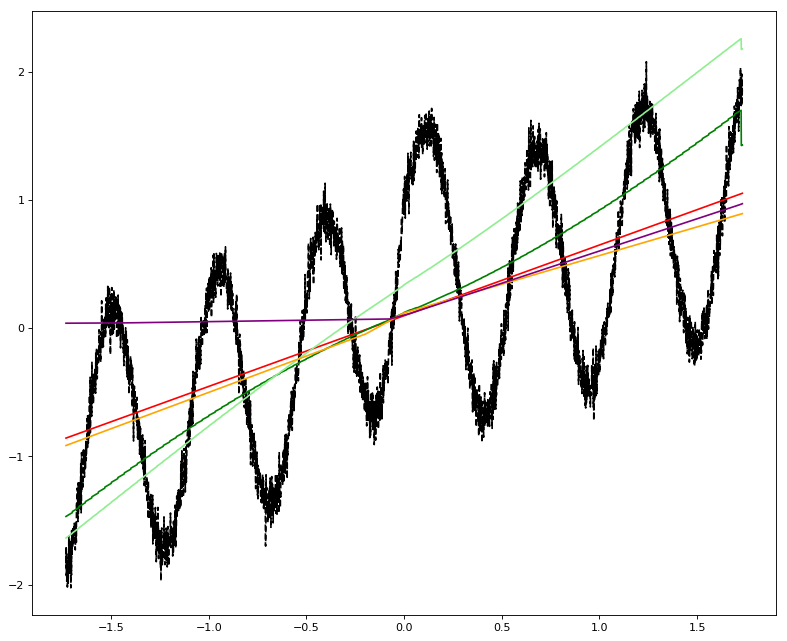

In [126]:
# Adjust Figure Details
plt.figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')

# Data Plot
plt.plot(data_x,data_y,color='k',label='true',linestyle='--')

# Plot Models
plt.plot(data_x,model_pred_y,color='red',label='OLS')
plt.plot(data_x,NEU_OLS_prediction[:,1],color='green',label='NEU-OLS')
plt.plot(data_x,NEU_OLS_greedy_initializations[:,1],color='lightgreen',label='NEU_Greedy_Init')
plt.plot(data_x,Deep_Ed_prediction[:,1],color='orange',label='Deep_Ed')
plt.plot(data_x,Deep_GLd_prediction[:,1],color='purple',label='Deep_GLd')

Succinct graph (results only)

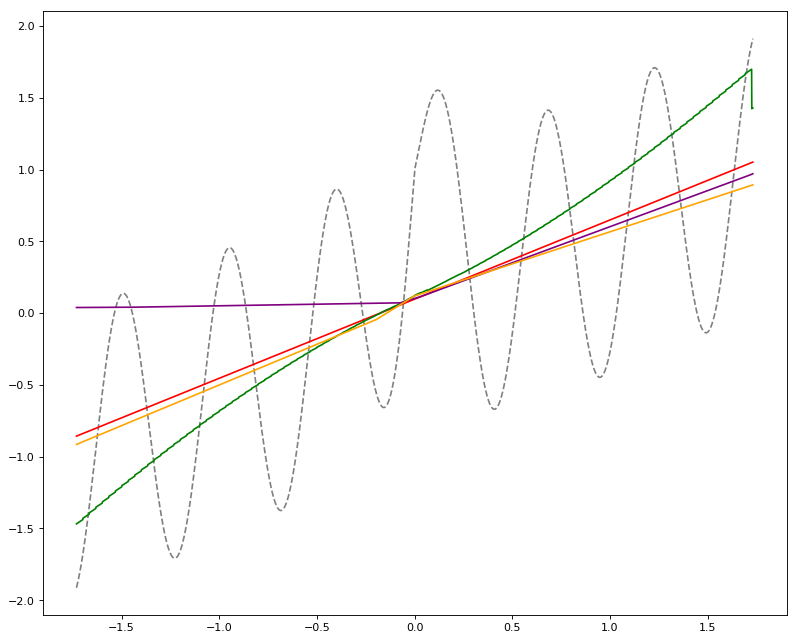

In [127]:
# Adjust Figure Details
plt.figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')

# Data Plot
plt.plot(data_x,true_y,label='true',color='grey',linestyle='--')

# Plot Models
plt.plot(data_x,model_pred_y,color='r',label='OLS')
plt.plot(data_x,NEU_OLS_prediction[:,1],color='green',label='NEU-OLS')
plt.plot(data_x,Deep_GLd_prediction[:,1],color='purple',label='Deep_GLd')
plt.plot(data_x,Deep_Ed_prediction[:,1],color='orange',label='Deep_Ed')

 ---

# Report Results

In [128]:
Results

,MAE,MinE,MaxE,Robust MAE,MSE
Deep GLd,0.672715,0.000157,1.579594,1.231703,0.598342
Deep ED,0.697659,0.000203,1.951776,1.243917,0.682368
NEU-OLS,0.645880,0.000184,1.475351,1.220045,0.531433


#### The END